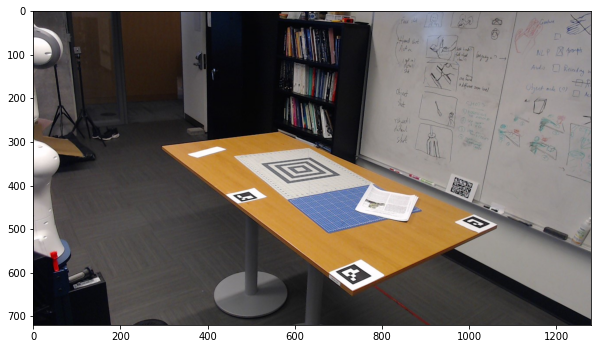

In [1]:
# Find tag positions in camera space
import cv2
import matplotlib.pyplot as plt

        
# Hide grid lines
fig, ax = plt.subplots(figsize=(10,10))
ax.grid(False)

img_path = 'calib_data/camera_shot_2.jpg'
    
im = cv2.imread(img_path)
plt.imshow(cv2.cvtColor(im, cv2.COLOR_BGR2RGB))
plt.show()

In [2]:
import numpy as np;
from yaml import load, dump
try:
    from yaml import CLoader as Loader, CDumper as Dumper
except ImportError:
    from yaml import Loader, Dumper

intrinsic_path = 'calib_data/c922-720p-calib.yaml'
with open(intrinsic_path) as fr:
    c = load(fr, Loader=Loader)
    cam_mat = np.array(c['camera_matrix'])
    distortion = np.array(c['dist_coefs'])

In [3]:
import cv2.aruco as aruco
aruco_dict = aruco.Dictionary_get(aruco.DICT_4X4_50)
aruco_param = aruco.DetectorParameters_create()

In [4]:
def __FindArucoMarkers(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    corners, ids, rejected = aruco.detectMarkers(gray, aruco_dict, parameters = aruco_param)
    #print(f"Marker ids are {ids}")
    ids = [ii[0] for ii in ids] if ids is not None else []
    # rv, tv, _o = aruco.estimatePoseSingleMarkers(corners, markerSide / 1000, camMat, dist)
    # rm = [cv2.Rodrigues(rvec)[0] for rvec in rv] # convert to rotation matrix
    # res = zip(ids, rm, tv) # (tagid, rotation_mat, translation_vec)
    #print(list(res))
    #print(ids)
    return corners, ids

In [5]:
def __FindMarkerPoses(corners, ids, ids_to_find, camMat, distParams, markerSize):
    selected_ids = [a for a in ids if a in ids_to_find]
    selected = [corners[i] for i in range(0, len(corners)) if ids[i] in ids_to_find]
    if len(selected_ids) > 0:
        rv, tv, _o = aruco.estimatePoseSingleMarkers(selected, markerSize / 1000, camMat, distParams)
        rm = [cv2.Rodrigues(rvec)[0] for rvec in rv] # convert to rotation matrix
        res = zip(selected_ids, rm, tv) # (tagid, rotation_mat, translation_vec)
        #print(list(res))
        #print(ids)
        return res
    else:
        return iter(())

In [6]:
marker_corners, marker_ids = __FindArucoMarkers(im)

In [7]:
tags_to_find = [0, 1, 2]
tag_size = 80 # in mm
irt = __FindMarkerPoses(marker_corners, marker_ids, tags_to_find, cam_mat, distortion, tag_size) 

In [8]:
results = {}
for tag_id, tag_rot, tag_trans in irt:
    results[tag_id] = tag_trans.flatten().tolist()
camera_corners = results

In [9]:
# Flip x-axis to make the Kinect coordinates righ-handed
kinect_corners = {0: [0.5917506, 0.5864837, 1.678829], 1: [0.6491743, 0.6695306, 0.7790866], 2: [-0.9571387, 0.6693855, 0.6765548], 3: [-1.014562, 0.5863385, 1.576297]}
# Offset Kinect corners by their margin
kinect_corner_0_full = np.array(kinect_corners[0])
kinect_corner_1 = np.array(kinect_corners[1])
kinect_corner_2 = np.array(kinect_corners[2])
kinect_corner_3_full = np.array(kinect_corners[3])
# center = (kinect_corner_one + kinect_corner_two) / 2
offset = (0.04 + 0.02) * 1.41414

kinect_corner_0 = kinect_corner_1 + (kinect_corner_0_full - kinect_corner_1) * 8.0 / 9.0
kinect_corner_3 = kinect_corner_2 + (kinect_corner_3_full - kinect_corner_2) * 8.0 / 9.0

kinect_midpoint_12 = (kinect_corner_1 + kinect_corner_2) / 2 
kinect_midpoint_03 = (kinect_corner_0 + kinect_corner_3) / 2
kinect_offset_direction_0 = kinect_midpoint_12 -  kinect_corner_0
kinect_offset_direction_0 = kinect_offset_direction_0 / np.linalg.norm(kinect_offset_direction_0)
kinect_offset_direction_2 = kinect_corner_1 - kinect_midpoint_03
kinect_offset_direction_2 = kinect_offset_direction_2 / np.linalg.norm(kinect_offset_direction_2)

# center_to_kc_one = center_to_kc_one / np.linalg.norm(center_to_kc_one)
kinect_corner_0_offset = kinect_corner_0 + kinect_offset_direction_0 * offset
kinect_corner_1_offset = kinect_corner_1 - kinect_offset_direction_2 * offset
kinect_corner_2_offset = kinect_midpoint_03 + kinect_offset_direction_2 * offset
kinect_points = np.transpose(np.array([kinect_corner_0_offset, kinect_corner_1_offset, kinect_corner_2_offset]))
kinect_points

array([[ 0.54206123,  0.58549402, -0.14134503],
       [ 0.60120894,  0.66402197,  0.60114717],
       [ 1.51541312,  0.83488739,  1.47179085]])

In [10]:
camera_points = np.transpose(np.array([camera_corners[0], camera_corners[1], camera_corners[2]]))
camera_points

array([[ 0.11625328,  0.66584277, -0.31246947],
       [ 0.36831421,  0.27071036,  0.17085183],
       [ 1.34479897,  1.78156163,  1.84931481]])

In [11]:
def rigid_transform_3D(A, B):
    assert A.shape == B.shape

    num_rows, num_cols = A.shape
    if num_rows != 3:
        raise Exception(f"matrix A is not 3xN, it is {num_rows}x{num_cols}")

    num_rows, num_cols = B.shape
    if num_rows != 3:
        raise Exception(f"matrix B is not 3xN, it is {num_rows}x{num_cols}")

    # find mean column wise
    centroid_A = np.mean(A, axis=1)
    centroid_B = np.mean(B, axis=1)

    # ensure centroids are 3x1
    centroid_A = centroid_A.reshape(-1, 1)
    centroid_B = centroid_B.reshape(-1, 1)

    # subtract mean
    Am = A - centroid_A
    Bm = B - centroid_B

    H = Am @ np.transpose(Bm)

    # sanity check
    #if linalg.matrix_rank(H) < 3:
    #    raise ValueError("rank of H = {}, expecting 3".format(linalg.matrix_rank(H)))

    # find rotation
    U, S, Vt = np.linalg.svd(H)
    R = Vt.T @ U.T

    # special reflection case
    if np.linalg.det(R) < 0:
        print("det(R) < R, reflection detected!, correcting for it ...")
        Vt[2,:] *= -1
        R = Vt.T @ U.T

    t = -R @ centroid_A + centroid_B

    return R, t

In [12]:
rigid_transform_3D(kinect_points, camera_points)


det(R) < R, reflection detected!, correcting for it ...


(array([[ 0.67608755,  0.14629449, -0.72215202],
        [ 0.28063961, -0.95734436,  0.06879817],
        [-0.68128337, -0.24917805, -0.68830463]]),
 array([[0.76331743],
        [0.68564012],
        [2.91446256]]))